In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt

from scipy.stats import norm
from dateutil import relativedelta
from pykrx import stock

In [2]:
def ch (name):
    cptype = name[7:8]
    maturity = name[9:15]
    strike = name[16:]

    return cptype+maturity+strike

def gamma (option_type, S, K, r, T, sigma):

    d1 = (np.log(S/K) + (r + 0.5 * (sigma ** 2)) * T ) / (sigma * np.sqrt(T))

    return stats.norm.pdf(d1) / (sigma * S * np.sqrt(T))

def new_next_exp(today):

    today = dt.datetime.strptime(today, '%Y-%m-%d')

    next_mon = today + relativedelta.relativedelta(months=1)
    nnext_mon = next_mon + relativedelta.relativedelta(months=1)

    if today.day < 15:
        result = next_mon
    else:
        result = nnext_mon
        
    return result.strftime("%Y%m")

def option_date_creator (week, date):
    '''마지막 만기 거래일이 나옴'''
    date = new_next_exp(date)
    base_date = dt.datetime.strptime(date, '%Y%m')
    option_date = base_date + relativedelta.relativedelta(weekday=3) + dt.timedelta(weeks=week)
    option_date = option_date.strftime('%Y-%m-%d')

    return option_date

def tau_creator (today, date):
    
    today = dt.datetime.strptime(today, '%Y-%m-%d')
    date = dt.datetime.strptime(date, '%Y-%m-%d')
    
    return (date - today).days/252

def tau_arr_creator (today, date):

    days = tau_creator(today, date) * 252
    
    return (np.flip(np.arange(0, days+1)) * 1/252).reshape(-1,1)

def delta_cal (s, k, r, q, vol, t):

    def d1_cal (s, k, r, q, vol, t):
        return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))
        
    return norm.cdf(d1_cal(s, k, r, q, vol, t))

def atm_mapping (df, s0):
    '''Option MultiIndex df with spot price'''
    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    atm_k = k_arr[np.where((s0 - k_arr)>0)][-1]

    return atm_k

def otm_mapping (df, s0, mul):

    k_arr = df.columns.get_level_values(2).unique().to_numpy().astype(float)
    otm_k = k_arr[np.where((s0 * (1 + mul) - k_arr)>0)][-1]

    return otm_k

def d1_cal (s, k, r, q, vol, t):
    return (np.log(s/k) +((r-q+0.5*np.power(vol, 2))*t))/(vol*np.sqrt(t))

def d2_cal (s, k, r, q, vol, t):
    return d1_cal(s, k, r, q, vol, t) - vol * np.sqrt(t)    

def gamma_cal (s, k, r, q, vol, t):
    
    return norm.pdf(d1_cal(s, k, r, q, vol, t)) / (s*vol*np.sqrt(t))

def theta_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''

    p1 = - s * norm.pdf(d1_cal(s, k, r, q, vol, t))*vol / (2 * np.sqrt(t))
    p2 = r * k * np.exp(-r*t) * norm.cdf(d2_cal(s, k, r, q, vol, t)) 

    if type is 'c':
        return p1 - p2
    else:
        return p1 + p2
    
def vega_cal (s, k, r, q, vol, t):
    return s * np.sqrt(t) * norm.pdf(d1_cal(s,k,r,q,vol,t))

def rho_cal (s, k, r, q, vol, t, type='c'):
    '''type is binary "c" or "p"'''
    if type is 'c':
        return k*t*np.exp(-r*t)*norm.cdf(d2_cal(s, k, r, q, vol, t))
    else:
        return -k*t*np.exp(-r*t)*norm.cdf(-d2_cal(s, k, r, q, vol, t))

<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_33070/2209694858.py:87: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is 'c':
/var/folders/0k/zyr795gx3hl6x1nytrrntcnc0000gn/T/ipykernel_33070/2209694858.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is 'c':


In [3]:
file_path = os.getcwd() + '/Data/'

kospi200 = stock.get_index_ohlcv('20050801', '20221130', '1028')['종가']
kospi200_vol = pd.DataFrame(np.log(kospi200).diff().rolling(60).std() * np.sqrt(252)).dropna()
kospi200_vol.index = pd.to_datetime(kospi200_vol.index)
rf = pd.read_csv(file_path + 'rf.csv', index_col=['Date'], parse_dates=True)

In [4]:
file_path = os.getcwd() + '/Data/'

df_close   = pd.read_pickle(file_path+'kospi200/'+'Call_data_close.pkl')
df_base    = pd.read_pickle(file_path+'kospi200/'+'Call_data_base.pkl')
df_volume  = pd.read_pickle(file_path+'kospi200/'+'Call_data_volume.pkl')
df_imvol   = pd.read_pickle(file_path+'kospi200/'+'Call_data_imvol.pkl')
df_open    = pd.read_pickle(file_path+'kospi200/'+'Call_data_open.pkl')

df_close2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_close.pkl')
df_base2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_base.pkl')
df_volume2  = pd.read_pickle(file_path+'kospi200/'+'Put_data_volume.pkl')
df_imvol2   = pd.read_pickle(file_path+'kospi200/'+'Put_data_imvol.pkl')
df_open2    = pd.read_pickle(file_path+'kospi200/'+'Put_data_open.pkl')


data_list = [df_close, df_base, df_volume, df_imvol, df_open,\
             df_close2, df_base2, df_volume2, df_imvol2, df_open2]

test = []
ttt = ['종가', '기준가', '거래량', '내재변동성', '미결제약정', '종가', '기준가', '거래량', '내재변동성', '미결제약정']

for idx, dfdfdfdf in enumerate(data_list):

    '''코스피일 경우엔 아래 진행'''

    tmp = dfdfdfdf.iloc[8:]
    tmp = tmp.set_axis(tmp.iloc[0], axis=1).drop(index=[8,9,10,11,12])

    tmp = tmp.rename(columns={tmp.columns[0] : 'Date'}).set_index('Date')
    tmp.index = pd.to_datetime(tmp.index)
    tmp.columns = [ch(x) for x in tmp.columns]

    '''코스피 아닐경우 바로 아래만 진행'''

    k_list = [x[7:] for x in tmp.columns]
    t_list = [x[1:7] for x in tmp.columns]
    c_list = [x[0] for x in tmp.columns]
    f_list = [ttt[idx] for x in tmp.columns]
    ppp = pd.DataFrame(data=tmp.values, index=tmp.index, columns=[c_list, t_list, k_list, f_list])
    test.append(ppp)

df = pd.concat(test, axis=1)#, keys=ttt)
#df.columns = df.columns.swaplevel(0, 1).swaplevel(1,2).swaplevel(2,3)
df.columns.names = ['cpflag', 'tick', 'strike', 'feature']
df


cpflag          C                                                          \
tick       200709                                                           
strike      165.0  167.5  170.0  172.5  175.0  177.5  180.0  182.5  185.0   
feature        종가     종가     종가     종가     종가     종가     종가     종가     종가   
Date                                                                        
2007-08-01   65.3  65.75   63.3   60.8  58.35   55.9  53.45     51   48.6   
2007-08-02   63.2   65.6   63.1  60.65   58.2  55.75   53.3   50.9  49.55   
2007-08-03  70.55  68.05     66   62.4  60.65   58.2  55.75  53.75  50.85   
2007-08-06   67.5  64.95   62.5     60   57.6   55.1   52.7  50.25  47.85   
2007-08-07     70  66.25  63.75   61.3  58.85  56.35   53.9  51.45     49   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2022-11-24    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-25    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-29    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2022-11-30    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

cpflag             ...      P                                                  \
tick               ... 202211                                                   
strike      187.5  ...  452.5 455.0 457.5 460.0 462.5 465.0 467.5 470.0 472.5   
feature        종가  ...  미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정 미결제약정   
Date               ...                                                          
2007-08-01   46.2  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-02  46.05  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-03  48.95  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-06   45.5  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2007-08-07   46.6  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...           ...  ...    ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-11-24    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-25    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-28    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-29    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-11-30    NaN  ...    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

cpflag            
tick              
strike     475.0  
feature    미결제약정  
Date              
2007-08-01   NaN  
2007-08-02   NaN  
2007-08-03   NaN  
2007-08-06   NaN  
2007-08-07   NaN  
...          ...  
2022-11-24   NaN  
2022-11-25   NaN  
2022-11-28   NaN  
2022-11-29   NaN  
2022-11-30   NaN  

[3789 rows x 84590 columns]

# Call 옵션을 통해 살펴본 Delta Hedging 손익

In [5]:
'''거래 승수 (만 단위)'''
mul = 5

'''Time 관련'''

date    = '2008-09-17'
exdate  = new_next_exp(date)
ex_date = option_date_creator(1, date)
#t       = tau_creator(date, ex_date)
#t_arr   = tau_arr_creator(date, ex_date)

'''포지션 비율'''

long_num = 1
short_num = 0

'''투자 Horizon'''

i_horizon   = len(kospi200.loc[date:ex_date])
tau_arr     = (np.flip(np.arange(0, i_horizon)) * 1/252).reshape(-1,1)
tau         = tau_arr[0].item()

'''Input Params'''

s0      = kospi200.loc[date]
s0_arr  = kospi200.loc[date:ex_date].to_numpy().reshape(-1,1)
s0_vol  = kospi200_vol.loc[date].values[0]
s0_vol_arr  = kospi200_vol.loc[date:ex_date].to_numpy().reshape(-1,1)
r       = rf.loc[date].values[0]

test        = pd.DataFrame(df.loc[date, ('C', exdate, slice(None), slice(None))]).T
atm_k       = atm_mapping(test, s0)
otm_k       = otm_mapping(test, s0, 0.15) 
op_pr_atm   = df.loc[date, ('C', exdate, str(atm_k), ['종가'])].values[0]
op_pr_otm   = df.loc[date, ('C', exdate, str(otm_k), ['종가'])].values[0]
iv          = df.loc[date, ('C', exdate, str(otm_k), ['내재변동성'])].values[0]

# '''Cost들'''

init_cost = - op_pr_atm * long_num #+ op_pr_otm * - long_num 

print(s0)
print(s0_vol)
print(init_cost * mul)
print(atm_k)
pd.DataFrame(df.loc[date, ('C', exdate, [str(atm_k), str(otm_k)], slice(None))])


183.54
0.2883647353175003
-53.25
182.5


2008-09-17
cpflag tick   strike feature           
C      200811 182.5  종가           10.65
                     기준가           8.35
                     거래량            248
                     내재변동성         0.32
                     미결제약정          660
              210.0  종가            1.46
                     기준가           1.44
                     거래량           2444
                     내재변동성        0.281
                     미결제약정         8360

In [6]:
atm_k, otm_k, iv, init_cost

(182.5, 210.0, 0.281, -10.65)

팔았으니 init_cost는 번게 된다 

In [7]:
s0

183.54

183.54


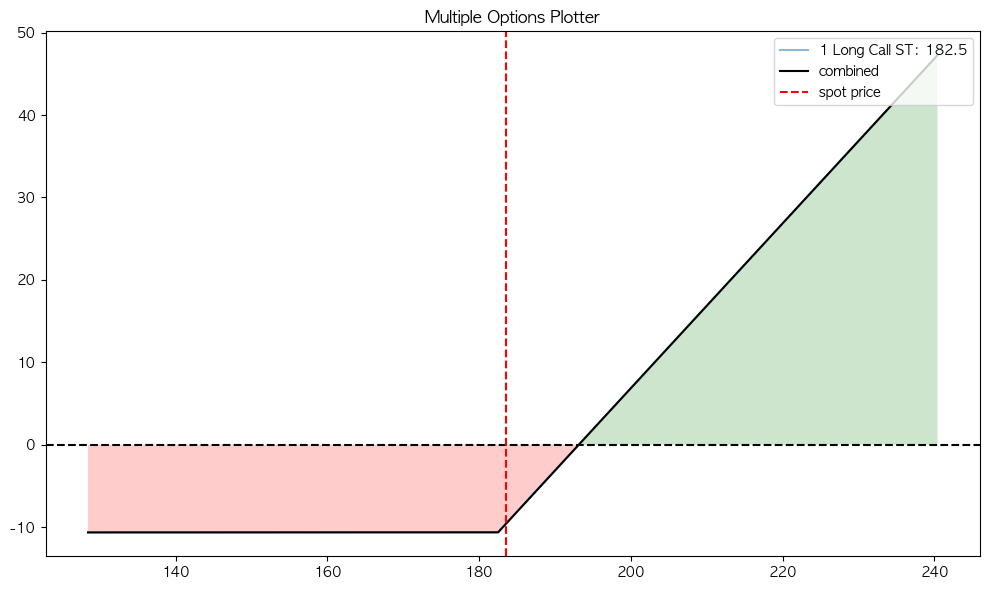

In [8]:
import opstrat as op

#op.single_plotter(spot=s0, strike=atm_k, op_type='c', tr_type='s', op_pr=op_pr_atm)

op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'b', 'op_pr':op_pr_atm}
#op_2 = {'op_type':'c', 'strike':otm_k, 'tr_type':'b', 'op_pr':op_pr_otm}

op_list = [op_1]#, op_2, op_2]
print(s0)
op.multi_plotter(spot=s0, spot_range=30, op_list=op_list)

In [9]:
tau

0.15873015873015872

팔았으니, 처음에 델타만큼 사야되서 short에는 -붙이고 Long에는 + 붙이는게 맞다

In [10]:
def path_changes (path_1):
    '''calculate path's changes'''

    return np.vstack([path_1[0], path_1[1:] - path_1[:-1]])

def create_hedging_df (s0_arr, atm_k, otm_k, r, q, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200):

    st_delta_path = \
    np.round(delta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr) * long_num, 4) \
             # + delta_cal(s0_arr, otm_k, r, 0, s0_vol, tau_arr) * short_num * 1, 3)

    st_delta_path = pd.DataFrame(st_delta_path, columns=['delta'])
    st_delta_path.index = kospi200.loc[date:ex_date].index

    st_delta_path['delta_ch'] = path_changes(st_delta_path.to_numpy())

    st_delta_path['gamma'] = np.round(gamma_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr), 4)
    st_delta_path['gamma_ch'] = path_changes(np.round(gamma_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr), 4))

    st_delta_path['theta'] = np.round(theta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr, type='c'), 4)
    st_delta_path['theta_ch'] = path_changes(np.round(theta_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr, type='c'), 4))

    st_delta_path['vega'] = np.round(vega_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr), 4)
    st_delta_path['vega_ch'] = path_changes(np.round(vega_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr), 4))
    
    st_delta_path['rho'] = np.round(rho_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr, type='c'), 4)
    st_delta_path['rho_ch'] = path_changes(np.round(rho_cal(s0_arr, atm_k, r, 0, s0_vol, tau_arr, type='c'), 4))

    st_delta_path['spot_price(Close)'] = s0_arr

    st_delta_path['Cost_ch'] = st_delta_path[['delta_ch']] * s0_arr

    st_delta_path['Cum_cost'] = st_delta_path['Cost_ch'].cumsum()

    st_delta_path['Hist_vol'] = s0_vol_arr

    return st_delta_path

aa = create_hedging_df(s0_arr, atm_k, otm_k, r, 0, s0_vol, tau_arr, long_num, short_num, date, ex_date, kospi200)
aa

,delta,delta_ch,gamma,gamma_ch,theta,theta_ch,vega,vega_ch,rho,rho_ch,spot_price(Close),Cost_ch,Cum_cost,Hist_vol
날짜,,,,,,,,,,,,,,
2008-09-17,0.5741,0.5741,0.0186,0.0186,-31.5754,-31.5754,28.6672,28.6672,15.1755,15.1755,183.54,105.370314,105.370314,0.288365
2008-09-18,0.4910,-0.0831,0.0196,0.0010,-30.8715,0.7039,28.1248,-0.5424,12.4806,-2.6949,179.25,-14.895675,90.474639,0.291478
2008-09-19,0.6605,0.1695,0.0174,-0.0022,-32.0845,-1.2130,26.7786,-1.3462,16.8763,4.3957,188.31,31.918545,122.393184,0.310424
2008-09-22,0.6760,0.0155,0.0172,-0.0002,-32.2418,-0.1573,26.0540,-0.7246,16.8807,0.0044,189.16,2.931980,125.325164,0.310687
2008-09-23,0.7177,0.0417,0.0162,-0.0010,-31.8237,0.4181,24.4735,-1.5805,17.5751,0.6944,191.58,7.988886,133.314050,0.309799
2008-09-24,0.7447,0.0270,0.0155,-0.0007,-31.4472,0.3765,23.1342,-1.3393,17.8258,0.2507,193.18,5.215860,138.529910,0.310430
2008-09-25,0.7572,0.0125,0.0152,-0.0003,-31.3862,0.0610,22.2780,-0.8562,17.6607,-0.1651,193.87,2.423375,140.953285,0.310611
2008-09-26,0.7057,-0.0515,0.0173,0.0021,-33.1857,-1.7995,23.7704,1.4924,15.8631,-1.7976,190.60,-9.815900,131.137385,0.308767
2008-09-29,0.6617,-0.0440,0.0189,0.0016,-34.3720,-1.1863,24.5135,0.7431,14.3401,-1.5230,188.10,-8.276400,122.860985,0.309107


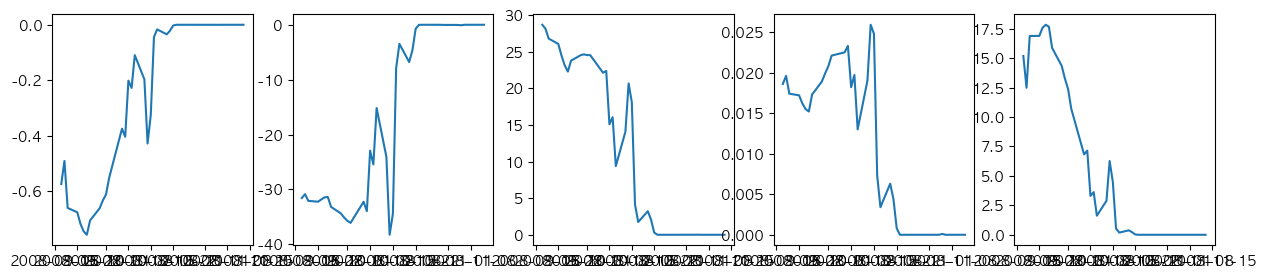

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(1,5,1)
plt.plot(-aa.delta)
plt.subplot(1,5,2)
plt.plot(aa.theta)
plt.subplot(1,5,3)
plt.plot(aa.vega)
plt.subplot(1,5,4)
plt.plot(aa.gamma)
plt.subplot(1,5,5)
plt.plot(aa.rho)

만기보유 가정시 포지션 청산시 이득

In [12]:
aa.iloc[-1]['Cum_cost']

15.239426999999957

In [13]:
init_cost

-10.65

In [14]:
# ((atm_k - aa['spot_price(Close)'].iloc[-1]) + 
(init_cost + aa.iloc[-1]['Cum_cost']) * mul

22.947134999999783

In [15]:
(aa.Hist_vol[-1] - aa.Hist_vol[0])

0.31037781584082824

# 섞은 걸로 체크해보자

NameError: name 'hist_vol' is not defined

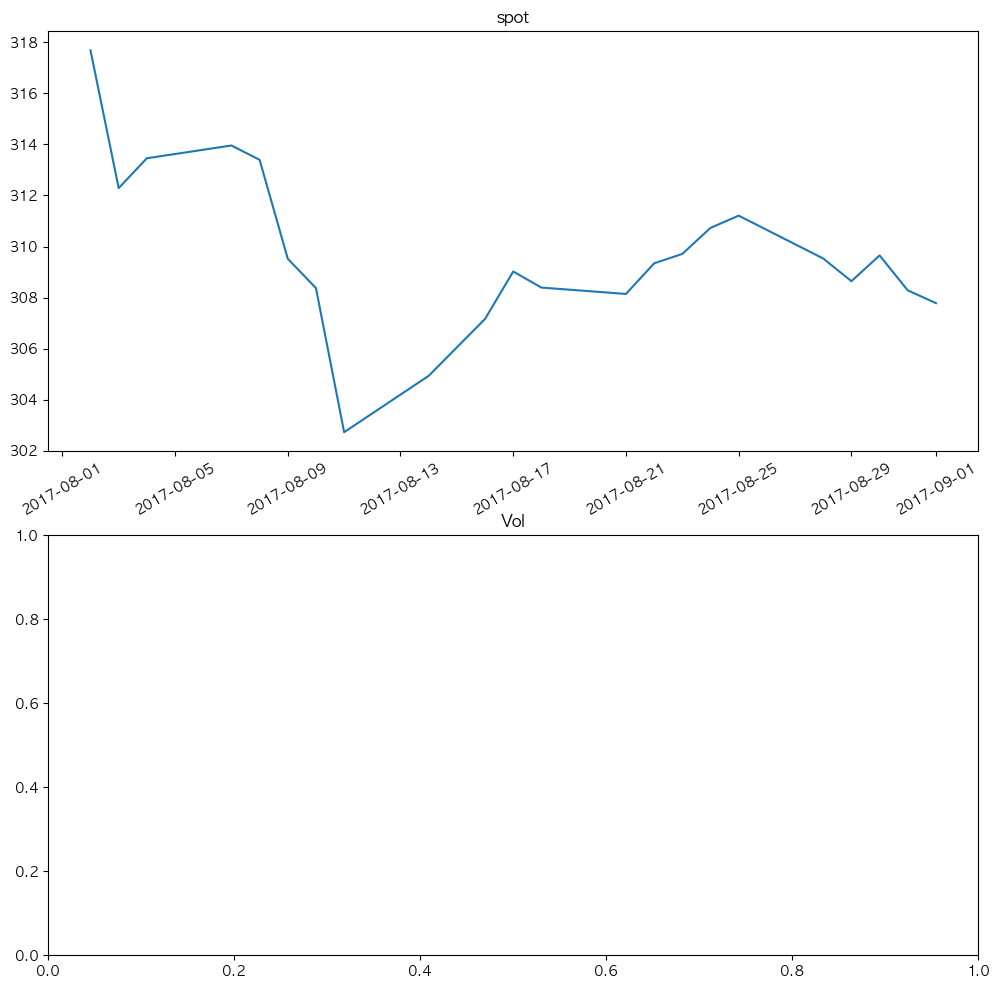

In [16]:
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.title('spot')
plt.plot(kospi200.loc['2017-08-02':'2017-09-02'])
plt.xticks(rotation=30)

plt.subplot(2,1,2)
plt.title('Vol')
plt.plot(hist_vol.loc['2017-08-02':'2017-09-02'])
plt.xticks(rotation=30)

plt.show()

변동성이 오를 것으로 가정해보자

In [ ]:
'''거래 승수 (만 단위)'''
mul = 5

'''Time 관련'''

date    = '2017-08-02'
exdate  = new_next_exp(date)
ex_date = option_date_creator(1, date)
#t       = tau_creator(date, ex_date)
#t_arr   = tau_arr_creator(date, ex_date)

'''포지션 비율'''

long_num = 1
short_num = 2

'''투자 Horizon'''

i_horizon   = len(kospi200.loc[date:ex_date])
tau_arr     = (np.flip(np.arange(0, i_horizon)) * 1/252).reshape(-1,1)
tau         = tau_arr[0].item()

'''Input Params'''

s0      = kospi200.loc[date]
s0_arr  = kospi200.loc[date:ex_date].to_numpy().reshape(-1,1)
s0_vol  = kospi200_vol.loc[date].values[0]
s0_vol_arr  = kospi200_vol.loc[date:ex_date].to_numpy().reshape(-1,1)
r       = rf.loc[date].values[0]

test        = pd.DataFrame(df.loc[date, ('C', exdate, slice(None), slice(None))]).T
atm_k       = atm_mapping(test, s0)
otm_k       = otm_mapping(test, s0, 0.15) 
op_pr_atm   = df.loc[date, ('C', exdate, str(atm_k), ['종가'])].values[0]
op_pr_otm   = df.loc[date, ('C', exdate, str(otm_k), ['종가'])].values[0]
iv          = df.loc[date, ('C', exdate, str(otm_k), ['내재변동성'])].values[0]

'''Cost들'''

init_cost = op_pr_otm * - short_num + op_pr_atm * long_num

print(s0_vol)
print(f'initial cost : {init_cost * mul}')
pd.DataFrame(df.loc[date, ('C', exdate, [str(atm_k), str(otm_k)], slice(None))])

0.09290351906767383
initial cost : 23.800000000000004


2017-08-02
cpflag tick   strike feature           
C      201709 317.5  종가            4.82
                     기준가           4.61
                     거래량            394
                     내재변동성        0.103
                     미결제약정         2290
              352.5  종가            0.03
                     기준가           0.02
                     거래량             73
                     내재변동성        0.116
                     미결제약정         4890

317.69


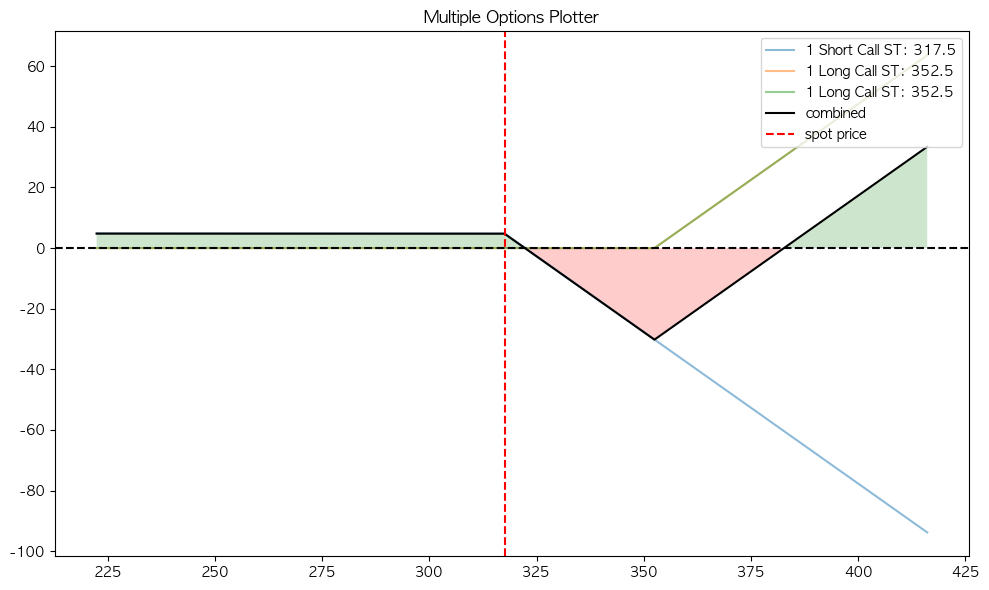

In [ ]:
import opstrat as op

#op.single_plotter(spot=s0, strike=atm_k, op_type='c', tr_type='s', op_pr=op_pr_atm)

op_1 = {'op_type':'c', 'strike':atm_k, 'tr_type':'s', 'op_pr':op_pr_atm}
op_2 = {'op_type':'c', 'strike':otm_k, 'tr_type':'b', 'op_pr':op_pr_otm}

op_list = [op_1, op_2, op_2]
print(s0)
op.multi_plotter(spot=s0, spot_range=30, op_list=op_list)